# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import acf
from scipy.stats import skew, kurtosis, wasserstein_distance

# Download Data

In [2]:
class YahooFinance:
    def __init__(self, symbol:str, start_date:str, end_date:str, interval:str='1d'):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.col_names = ["date", 'price', 'log_return']
    
    def _download_data(self, symbol:str|list[str], start_date:str, end_date:str, interval:str='1d') -> pd.DataFrame:
        prices = yf.download(symbol, start=start_date, end=end_date, interval=interval, auto_adjust=False)
        prices.index = prices.index.date
        return prices
    
    def _filter_cols(self, prices:pd.DataFrame) -> pd.DataFrame:
        filtered_prices = prices['Adj Close'].copy()
        filtered_prices.columns = ['Adj Close']
        return filtered_prices
    
    def _pct_change(self, filtered_prices:pd.DataFrame) -> pd.DataFrame:
        df = filtered_prices.copy()
        df['log_return'] = np.log(df['Adj Close']/ df['Adj Close'].shift(1))
        return df
    
    def _reset_index(self, filtered_prices:pd.DataFrame) -> pd.DataFrame:
        df = filtered_prices.reset_index(names='Date', drop=False).copy()
        df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d/%m/%Y')
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y') #Convert from string to datetime
        return df
    
    def pipeline(self) -> pd.DataFrame:
        prices = self._download_data(self.symbol, self.start_date, self.end_date, self.interval)
        filtered_prices = self._filter_cols(prices)
        df = self._reset_index(filtered_prices)
        df = self._pct_change(df)
        df.columns = self.col_names
        df.set_index('date', drop=True, inplace=True)
        return df

In [3]:
params = {
    'symbol': 'SPY',
    'start_date': '2000-01-01',
    'end_date': '2025-12-31'
}
yahoo = YahooFinance(**params)
df = yahoo.pipeline()
df.head(5)

[*********************100%***********************]  1 of 1 completed


,price,log_return
date,,
2000-01-03,91.617043,NaN
2000-01-04,88.034233,-0.039892
2000-01-05,88.191757,0.001788
2000-01-06,86.774384,-0.016202
2000-01-07,91.813904,0.056452


# Stationary Block Boostrapping (SBB)

In order to realistically simulate the SPY returns, there are two important properties that must hold: (i) Convergence in Distribution and (ii) Volatility Clustering.

Therefore, we will utilize the SBB due to the following properties:
- **Local Stationarity Holds Over Short Horizons**: The bootstrap resamples short, contiguous blocks in which the distribution of returns is approximately stable. By stitching these blocks together, it preserves short-range dependence.
- **Convergence in Distribution**: As $n \to \infty$ and $t \to \infty$ at a slower rate than $n$, the bootstrap distribution converges to the same asymptotic distribution as the original data.
- **Volatility Clustering**: Financial returns exhibit autocorrelation and breaking structure also destroys this property. However, block bootstrap preserves short-range dependence within blocks and will be at least partially preserved.

Nonetheless, there will be limitations:
- **Finite-sample issue**: With short samples or poorly chosen block length, volatility dynamics may be distorted.
- **Long-memory volatility**: Requires very large blocks, which reduces resample diversity.
- **No new volatility shocks or unseen data**: Bootstrap cannot create what was not observed.

In [4]:
def stationary_bootstrap(data:np.ndarray, n_sims:int=1, t:int=252, avg_block_size:int=None, seed:int=None) -> np.ndarray:
    rng = np.random.default_rng(seed)
    T = len(data)
    sims = np.zeros((n_sims, t))
    if avg_block_size is None:
        avg_block_size = int(np.floor(T**(1/3)))
    
    restart_prob = 1/avg_block_size
    
    for i in range(n_sims):
        array_idx = 0
        while array_idx < t:
            if array_idx == 0 or rng.random() < restart_prob:
                idx = rng.integers(T)
            else:
                idx = (idx + 1) % T #Implement circular indexing
            
            sims[i, array_idx] = data[idx]
            array_idx += 1
    
    return sims

In [5]:
initial_params = {
    'data': df['log_return'].dropna().to_numpy(),
    'n_sims': 1,
    't': 5000,
    'avg_block_size': None,
    'seed': 123
}

initial_bootstrap = stationary_bootstrap(**initial_params)
initial_bootstrap

array([[ 0.00113306,  0.0006022 ,  0.00388708, ..., -0.00419622,
         0.00760223, -0.01400805]], shape=(1, 5000))

# Automatic Block Size Selection Methodology
In block bootstrapping, increasing the block size reduces bias because larger blocks better preserve the original, long-range temporal dependence structure of the data. however, excessively large blocks reduce the number of independent resampling blocks, leading to higher variance in the bootstrap estimator. Consequently, block length selection involves a bias–variance tradeoff, and the optimal block size is chosen to be the smallest value that adequately captures the dependence structure while minimizing variance.

With that in mind and the fact that time-series data is typically dependent on previous values, we have the following notation for long-run variance:
$$\sigma^2_\infty = \gamma(0) + 2\sum^\infty_{k=1}\gamma(k)$$
where $\gamma(k) = Cov[X_0, X_k]$ and where $k$ is the lag.

## Minimize the MSE
The best expected blocksize for the SBB is determined by minimizing the MSE as denoted:
$$
\text{MSE}(\hat{\sigma}_b^2) = 
\underbrace{\text{Bias}^2}_{\text{block too short}} + 
\underbrace{\text{Variance}}_{\text{blocks too long}}
$$

Here, we can break it down into its components:
$$Bias[\hat{\sigma}^2_b] = E[\sigma^2_b] - \sigma^2_{\infty} = -\frac{1}{b}G + o\left(\frac{1}{b}\right)$$
$$V[\hat{\sigma}^2_b] = \frac{b}{N}D + o\left(\frac{b}{N}\right)$$
$$G = \sum^\infty_{k=-\infty}|k|R(k) \qquad D = 2g^2(0) \qquad g(\omega) = \sum^\infty_{s=-\infty}R(s)cos(\omega s)$$

The above equations have some confusing notations, and hence we will clarify the intent and meaning of each:
- $o\left(\frac{1}{b}\right)$ and $o\left(\frac{b}{N}\right)$ indicate that the remainder terms disappear faster than the primary terms as the sample size $N$ and block size $b$ grows.
- $\sigma^2_{\infty}$ is the true asymptotic variance of the sample mean.
- $D$ represents the variance constant for the SBB or how noisy each block-level contribution is.
- $g(\omega)$ is the spectral density function, if your process has large low-frequency power (strong persistence / volatility clustering), every block carries a lot of correlated noise.
- $R(k)$ or $R(s)$ is simply a different notation for $\gamma(k)$ and $\gamma(s)$, they have equivalent meaning.

Lastly, $G$ is harder to understand by itself. It is easier to understand if we look at how it affects the Bias term.
$$Bias[\hat{\sigma}^2_b]= -\frac{1}{b}G + o\left(\frac{1}{b}\right)$$
 
The negative sign is included because the SBB cuts the time series into chunks, destroying some correlation and that means less long-run variance, leading to an estimate that is bias downwards. Moreover, at lag $k$, dependence survive with probability $1 - \frac{|k|}{b}$ and broken with probability $\frac{|k|}{b}$. Naturally, this leads to the following weighted-sum equation:
$$Bias[\hat{\sigma}^2_b] \approx -\sum^\infty_{k=-\infty}\frac{|k|}{b}R(k)$$
$$Bias[\hat{\sigma}^2_b] \approx -\frac{1}{b}G$$

This leads us to the final MSE equation:
$$\text{MSE}(\hat{\sigma}_b^2) = \frac{G^2}{b^2} + D\frac{b}{N} + o(b^{-2}) + o(b/N)$$

If we want to minimize MSE, we would choose:
$$b = \left(\frac{2G^2}{D}\right)^{1/3} N^{1/3}$$
$$\text{MSE}(\hat{\sigma}_b^2) \approx \frac{3}{2^{2/3}}\frac{G^{2/3}D^{2/3}}{N^{2/3}}$$

## Flat-Top Lag-Window
However, we have a problem in estimating the unknown infinite sums. The authors propose the "flat-top" lag-window as it provides accurate smoothing and fast convergence rate by taking advantage of the exponential decay of autocovariance. The flat-top lag window denoted as $\lambda(t)$ is defined by its symmetric trapezoidal shape, where the "flat top" refers to the region where $∣t∣ \leq 1/2$, meaning the sample autocovariances for these lags are given a full weight of 1.

$$\hat{g}(\omega) = \sum^M_{k=-M}\lambda(k/M)\hat{R}(k)cos(\omega k)$$
$$\hat{G} = \sum^M_{k=-M}\lambda(k/M)|k|\hat{R}(k)$$
$$\hat{R}(k) = \frac{1}{N}\sum^{N-|k|}_{i=1}(X_i - \bar{X}_N)(X_{i+|k|} - \bar{X}_N)$$

$$
\lambda(t) = 
\begin{cases}
1 & \text{if } |t| \in [0, 0.5] \\
2(1 - |t|) & \text{if } |t| \in [0.5, 1] \\
0 & \text{otherwise}
\end{cases}
$$
where $t$ represents the ratio $k/M$, $k$ is the lag and $M$ is the chosen bandwidth.

Since we are truncating the infinite sum, we are introducing bias. Consequently, we aim to minimize the bias:
- **AR(p)**: By taking advantage of the fact that the autocorrelation eventually becomes negligible or dies out exponentially, $\lambda$ includes the lower lags and ignore the higher lags.
- **MA(q)**: The key property is $\gamma(k) = 0$ for all $|k| > q$. This means that if we set $M=2q$, we constrain $\lambda(k/M) \in [0, 0.5]$ because if $k$ is more than $q$ the autocovariance is 0. Hence, all relevant lags are already included.

## Adaptive Bandwidth Choice
The flat-top lag-window requires a bandwidth $M$ which the authors propose using $2\hat{m}$, where $\hat{m}$ is the point at which the smallest autocorrelation lag that is not statistically significant from 0.

Below detail the steps:
1. Let $\hat{p}(k) = \hat{R}(k)/\hat{R}(0)$.
2. For $k=1,...,K_N$, where $K_N$ is a positive, nondecreasing integer-valued function such that $K_N = o(log N)$, the recommended practical values are $c = 2$ and $K_N = \text{max}\left(5, \sqrt{log_{10}N}\right)$.
3. $\hat{m}$ is the smallest positive integar such that $|\hat{p}(\hat{m}+k)| < c\sqrt{logN/N}$, where $c>0$ is a fixed constant.
4. Set $M = 2\hat{m}$.

This has already been implemented by the authors with some modifications, and we will simply refactor the code in Python: https://public.econ.duke.edu/~ap172/opt_block_length_REV_dec07.txt

In [6]:
def adaptive_bandwidth(data:np.ndarray, c:int=2, raise_error:bool=True) -> int:
    n = len(data)
    K = max(5, np.sqrt(np.log10(n)))
    max_M = np.ceil(np.sqrt(n)) + K #Add K-lags to give some leeway
    
    threshold = c*np.sqrt(np.log10(n) / n)
    p = acf(data, nlags=max_M)[1:] #Drop lag 0
    abs_p = np.abs(p)
    is_below_threshold = abs_p < threshold
    
    for m in range(int(max_M - K)):
        if is_below_threshold[m:m+K].all():
            m_hat = m+1
            break #If break does not occur, run the else statement
    else:
        p_above_threshold = np.where(abs_p >= threshold)[0] #Index 0 selects the inner array
        m_hat = p_above_threshold.max() + 1 if p_above_threshold.size else 0 #Return the index + 1, else if there are no values >= threshold return 0
    
    if raise_error and m_hat <= 0:
        raise ValueError(f"Estimated m_hat is less than or equal to 0: {m_hat}")
    
    M = min(2*m_hat, max_M)
    return M

In [7]:
data = df['log_return'].dropna().values
print(f"Optimal adaptive bandwidth is: {adaptive_bandwidth(data)}")

Optimal adaptive bandwidth is: 4


In [8]:
def flat_top_lag_window(t:np.ndarray) -> np.ndarray:
    abs_t = np.abs(t)
    window = np.zeros_like(abs_t, dtype=float)
    window[abs_t<=0.5] = 1.0
    
    mask = (abs_t > 0.5) & (abs_t<=1.0)
    window[mask] = 2.0*(1.0-abs_t[mask])
    return window

def sample_autocovariance(data:np.ndarray, k:np.ndarray) -> np.ndarray:
    n = len(data)
    x_bar = data.mean()
    centered_x = data - x_bar
    
    R = np.zeros_like(k, dtype=float)
    for idx, lag in enumerate(k):
        abs_lag = np.abs(lag)
        R[idx] = centered_x[:n-abs_lag]@ centered_x[abs_lag:]/ n
    return R

def long_run_variance_components(data:np.ndarray, M:int) -> tuple[float, float]:
    k = np.arange(-M, M+1, dtype=int)
    lambda_vals = flat_top_lag_window(k/M)
    R_hat = sample_autocovariance(data, k)
    
    g_hat = np.sum(lambda_vals*R_hat) #cos(0) = 1
    G_hat = np.sum(lambda_vals* np.abs(k)* R_hat)
    D_hat = 2.0* g_hat**2
    return G_hat, D_hat

def optimal_stationary_block_size(data:np.ndarray, c:int=2) -> int:
    n = len(data)
    M = adaptive_bandwidth(data, c)
    G_hat, D_hat = long_run_variance_components(data, M)
    block_size = (2* G_hat**2 / D_hat)**(1/3)* n**(1/3)
    max_block_size = np.ceil(min(3*np.sqrt(n), n/3)) #Upper bound on estimated optimal block length
    return min(block_size, max_block_size)

In [9]:
avg_block_size = int(np.ceil(optimal_stationary_block_size(data**2)))
print(f"The optimal block size for squared returns is: {avg_block_size}")

The optimal block size for squared returns is: 140


# Verifying Validity
## Autocorrelation Function Plot
Autocorrelation measures the linear relationship between lagged values of a time series. For example, $r_1$ measures $y_t$ and $y_{y-1}$.
$$
r_k = \frac{\sum^T_{t=k+1}(y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum^T_{t=1}(y_t - y)^2}
$$
where $T$ is the length of the time series, $\bar{y}$ is the mean of the series, $k$ is the lag (or time delay).

Source: https://otexts.com/fpp2/autocorrelation.html

In [10]:
class ACFPlot:
    def __init__(self, data:np.ndarray, sims:np.ndarray, max_lag:int, alpha:float=0.05):
        self.data = data.copy()
        self.sims = sims.copy()
        self.max_lag = int(max_lag)
        self.alpha = alpha
    
    def _acf_results(self) -> tuple[np.ndarray, np.ndarray]:
        acf_u = acf(self.data, nlags=self.max_lag)
        acf_b  = np.array([acf(self.sims[i], nlags=self.max_lag) for i in range(len(self.sims))])
        return (acf_u, acf_b)
    
    def _get_bounds(self) -> tuple[float, float]:
        interval = self.alpha*100/2
        lb, ub = interval, 100-interval
        return (lb, ub)
    
    def _bootstrap_stats(self, acf_b:np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        lb, ub = self._get_bounds()
        acf_b_mean = acf_b.mean(axis=0)
        acf_b_lo = np.percentile(acf_b, lb, axis=0)
        acf_b_hi = np.percentile(acf_b, ub, axis=0)
        return (acf_b_mean, acf_b_lo, acf_b_hi)
    
    def plot_acf_band(self, title:str) -> plt.Figure:
        acf_u, acf_b = self._acf_results()
        acf_b_mean, acf_b_lo, acf_b_hi = self._bootstrap_stats(acf_b)
        lags = np.arange(self.max_lag+1)
        
        plt.figure(figsize=(8,5))
        plt.fill_between(
            lags, acf_b_lo, acf_b_hi,
            color='lightblue', alpha=0.4, label=f'Bootstrap {100-self.alpha*100}% CI'
        )
        
        plt.plot(lags, acf_b_mean, color='blue', linewidth=2, label='Bootstrap Mean ACF')
        plt.plot(lags, acf_u, color='black', linestyle='--', linewidth=2, label='Underlying ACF')
        plt.axhline(0, color='gray', linewidth=1)
        
        plt.xlabel("Lag")
        plt.ylabel("ACF")
        plt.title(str(title))
        plt.legend()
        
        plt.grid(alpha=0.3)
        plt.tight_layout()
        return plt.gcf()

Next, we will validate the effectiveness of the SBB with automatic block selection by looking at the ACF of the returns and the squared returns as a proxy of volatility:
- **Returns**: The underlying ACF lies well within the 95% bootstrap confidence band across all lags, and the bootstrap mean ACF closely tracks the empirical ACF. This indicates that the SBB does not introduce spurious linear dependence and correctly reproduces the underlying behavior of returns.
- **Volatility**: The underlying ACF of squared returns exhibits strong persistence and slow decay, reflecting volatility clustering. The bootstrap confidence band successfully covers the empirical ACF across lags, and the bootstrap mean captures both the level and the decay pattern of volatility dependence. This suggests that an average block size of 140 is sufficient to preserve the second-moment dependence structure.

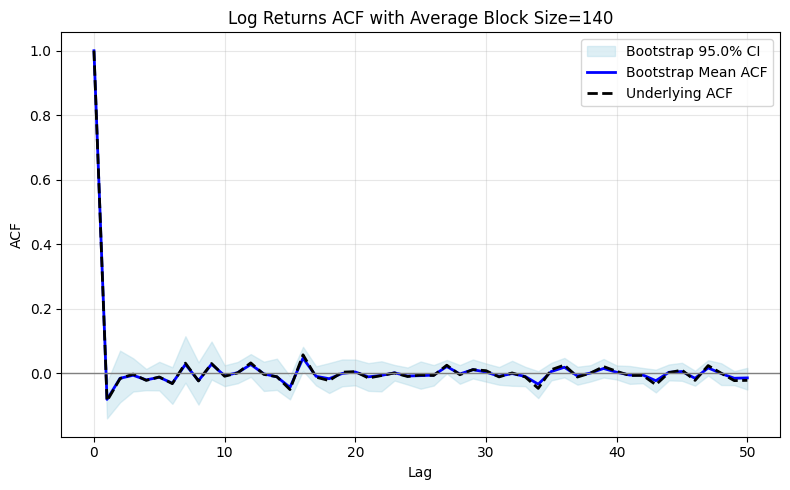

In [ ]:
steps = len(data)
max_lag = 50
alpha = 0.05
seed = 123

sims = stationary_bootstrap(data, n_sims=1000, t=steps, avg_block_size=avg_block_size, seed=seed)
vc = ACFPlot(data, sims, max_lag, alpha)
fig1 = vc.plot_acf_band(title=f'Log Returns ACF with Average Block Size={avg_block_size}')

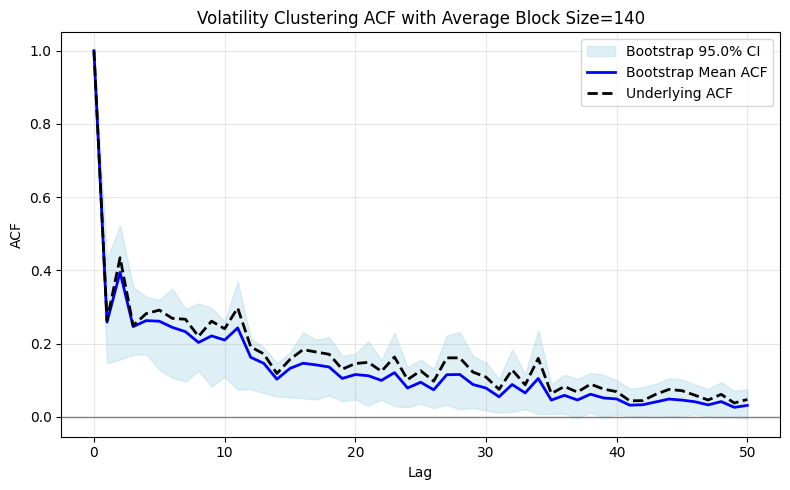

In [12]:
vc = ACFPlot(data**2, sims**2, max_lag, alpha)
fig1 = vc.plot_acf_band(title=f'Volatility Clustering ACF with Average Block Size={avg_block_size}')

## Matching of Moments

To further assess the generative adequacy of the SBB, we examine how effective the bootstrap distribution reproduces the first four central moments of the empirical log return distribution. Specifically, for each bootstrap path we compute the sample mean, volatility (standard deviation), skewness, and kurtosis, and compare their distributions to the corresponding moments computed from the original data.

In [13]:
def calculate_simulation_moments(sims:np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    bootstrap_mean = np.mean(sims, axis=1)
    bootstrap_std = np.std(sims, axis=1)
    bootstrap_skew = skew(sims, axis=1)
    bootstrap_kurt = kurtosis(sims, axis=1)
    return bootstrap_mean, bootstrap_std, bootstrap_skew, bootstrap_kurt

bootstrap_mean, bootstrap_std, bootstrap_skew, bootstrap_kurt = calculate_simulation_moments(sims)

In [14]:
actual_mean = np.mean(data)
actual_std = np.std(data)
actual_skew = skew(data)
actual_kurt = kurtosis(data)

The dashed red line in each panel denotes the empirical moment estimated from the observed log returns, while the histogram shows the distribution of the same moment across bootstrap samples.

Below is the moment matching diagnostics:
- **Mean**: The bootstrap distribution of the mean is centered around the empirical estimate, with the observed mean lying well within the high-density region of the bootstrap distribution.
- **Volatility**: The distribution of bootstrap volatilities is tightly concentrated around the empirical volatility.
- **Skewness**: The bootstrap distribution of skewness is more dispersed than those of the first two moments, reflecting the higher sampling variability associated with third-order moments. Nonetheless, the empirical skewness lies comfortably within the bootstrap distribution. Of note, in this case, the bootstrap paths seem to be more negative skewed than the underlying data. 
- **Kurtosis**: The bootstrap distribution of kurtosis exhibits substantial dispersion indicating fragility of fourth-order moment estimates in finite samples. Despite this variability, the empirical kurtosis falls within the central mass of the bootstrap distribution, suggesting that the SBB preserves the heavy-tailed nature of returns.

Taken together, these results indicate that the SBB achieves effective moment matching across the first four central moments. Lower-order moments (mean and volatility) are tightly matched, while higher-order moments (skewness and kurtosis) are at the very least in the ballpark.

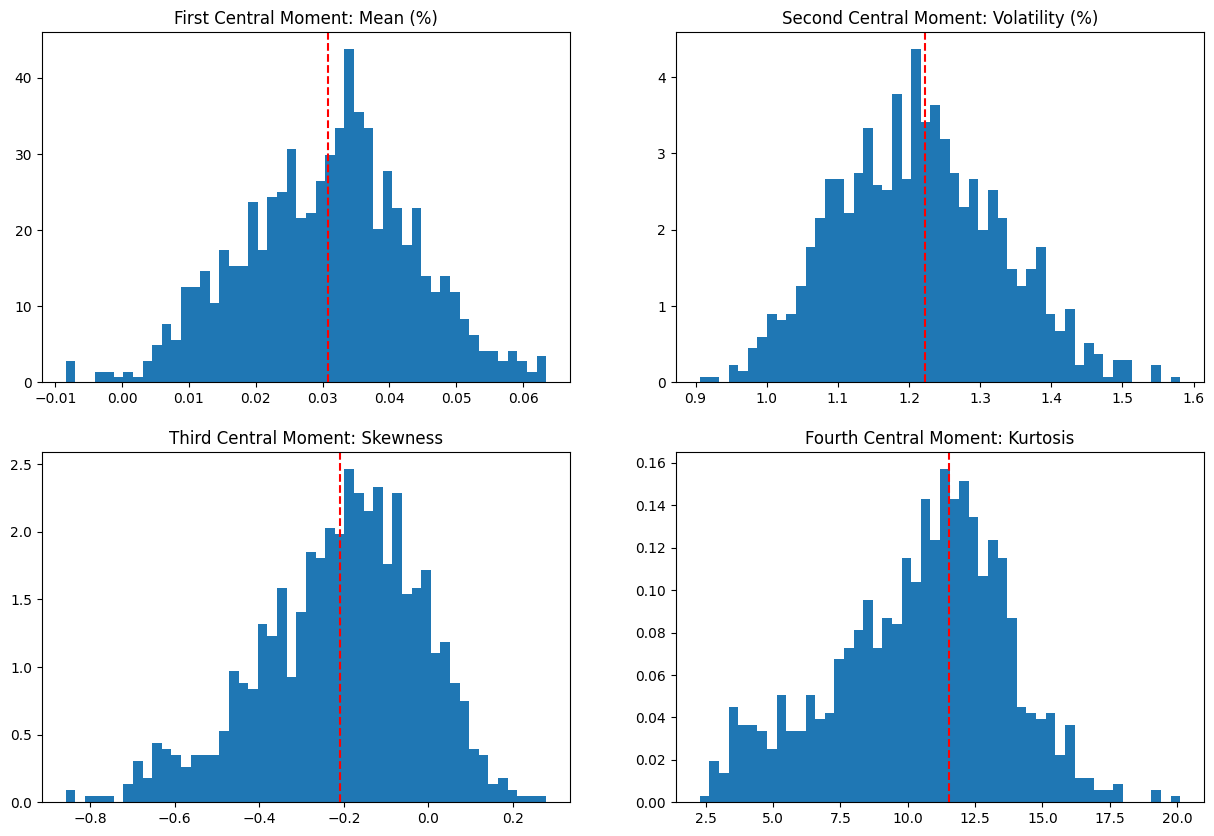

In [15]:
def plot_moment_distributions(ax, sim_moments:np.ndarray, actual_moment:float, title:str) -> plt.Figure:
    ax.hist(sim_moments, bins=50, density=True)
    ax.axvline(actual_moment, color='red', linestyle='--')
    ax.set_title(title)

titles = ["First Central Moment: Mean (%)", "Second Central Moment: Volatility (%)", "Third Central Moment: Skewness", "Fourth Central Moment: Kurtosis"]
fig, axes = plt.subplots(ncols=2,nrows=2, figsize=(15,10))
plot_moment_distributions(axes[0][0], bootstrap_mean*100, actual_mean*100, titles[0])
plot_moment_distributions(axes[0][1], bootstrap_std*100, actual_std*100, titles[1])
plot_moment_distributions(axes[1][0], bootstrap_skew, actual_skew, titles[2])
plot_moment_distributions(axes[1][1], bootstrap_kurt, actual_kurt, titles[3])
plt.show()

## Sensitivity to Number of Repetitions per Path

In order to evaluate the similarity between the bootstrap distribution and the underlying distribution, we will use the Wasserstein Distance. Essentially, it is the minimum cost of moving and transforming a pile of sand in the shape of one probability distribution to the shape of the other, where the cost is the amount of sand transported multiplied by the distance.
$$W(P_1, P_2) = \inf_{\pi \sim \Pi(P_1, P_2)}E_{(x,y) \sim \pi}[c(x,y)]$$
$$W(P_1, P_2) = \inf_{\pi \sim \Pi(P_1, P_2)}\int_{\chi \times \chi}\pi(x,y)c(x,y)dxdy$$
where $\Pi(P_1, P_2)$ is the set of all possible joint probability distributions, $\pi \sim \Pi$ describes one potential transport plan, $c(x,y)$ is the cost of transporting one unit mass, and $\chi \times \chi$ is the support of the probability distribution of the coupling or the transport plan $\pi$.

In general, this optimization problem does not admit a closed-form solution and can be computationally expensive. However, in the one-dimensional case, it can be simplified into the following notation:
$$W(P_1, P_2) = \inf_{\pi \sim \Pi(P_1, P_2)}\int_{\chi \times \chi}\pi(x,y)c(x,y)dxdy$$
$$W(P_1, P_2) = \int^1_0|F^{-1}_{P_1}(u) - F^{-1}_{P_2}(u)|du$$

After sorting the data in $P_1$ and $P_2$, we can solve for the Riemann approximation:
$$W(P_1, P_2) \approx \frac{1}{n}\sum^n_{i=1}|x_{(i)} - y_{(i)}|$$

Sources:
- https://lilianweng.github.io/posts/2017-08-20-gan/#what-is-wasserstein-distance
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [16]:
t_steps = [int(np.ceil(len(data)*i)) for i in np.arange(0.1, 1.0+0.1, 0.1)]
rep_sims = [stationary_bootstrap(data, n_sims=1000, t=t, avg_block_size=avg_block_size, seed=seed) for t in t_steps]

As the timestep length grows, the Wasserstein distance decreases monotonically, indicating that the empirical distribution of the bootstrap samples starts to better represent the underlying distribution of the observed data. 

Importantly, the rate of decline diminishes at higher timesteps, suggesting convergence at which additional increases in path length yield marginal improvements.

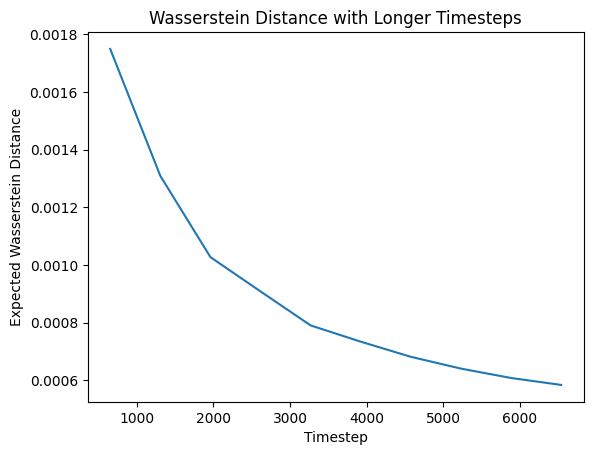

In [17]:
expected_distances = [np.mean([wasserstein_distance(path, data) for path in sim]) for sim in rep_sims]
plt.plot(t_steps, expected_distances)
plt.title("Wasserstein Distance with Longer Timesteps")
plt.xlabel("Timestep")
plt.ylabel("Expected Wasserstein Distance")
plt.show()

Next, we evaluate the absolute deviation of central moments between the bootstrap distribution and the underlying distribution, measured relative to the bootstrap median. 

In [20]:
def calculate_abs_distance_from_median(target:float, actual:float) -> float:
    return np.abs(np.median(target) - actual)

results = []
for sim in rep_sims:
    mu, vol, s, k = calculate_simulation_moments(sim)
    entry = {
        'mu_median_distance': calculate_abs_distance_from_median(mu, actual_mean),
        'std_median_distance':  calculate_abs_distance_from_median(vol, actual_std),
        'skew_median_distance': calculate_abs_distance_from_median(s, actual_skew),
        'kurt_median_distance': calculate_abs_distance_from_median(k, actual_kurt)
    }
    results.append(entry)

results = pd.DataFrame(results)
results['timesteps'] = t_steps
results.head(5)

,mu_median_distance,std_median_distance,skew_median_distance,kurt_median_distance,timesteps
0,0.000071,0.001111,0.000689,8.434585,654
1,0.000018,0.000689,0.040069,5.556367,1308
2,0.000014,0.000358,0.025002,3.267077,1962
3,0.000011,0.000322,0.036142,1.946365,2615
4,0.000010,0.000127,0.036023,1.362853,3269


For the first two moments, the absolute distance from the median declines steadily as the timestep length increases, indicating improved stability and convergence of the bootstrap estimates with longer simulated paths. A similar reduction is observed for kurtosis; however, this behavior should not be expected to hold universally, as higher-order moments beyond the second are well known to be fragile in finite samples. 

In contrast, the skewness deviation exhibits greater variability and does not decrease monotonically. One could aruge that it does not display a systematic upward trend, suggesting that increasing the timestep length does not exacerbate skewness estimation errors.

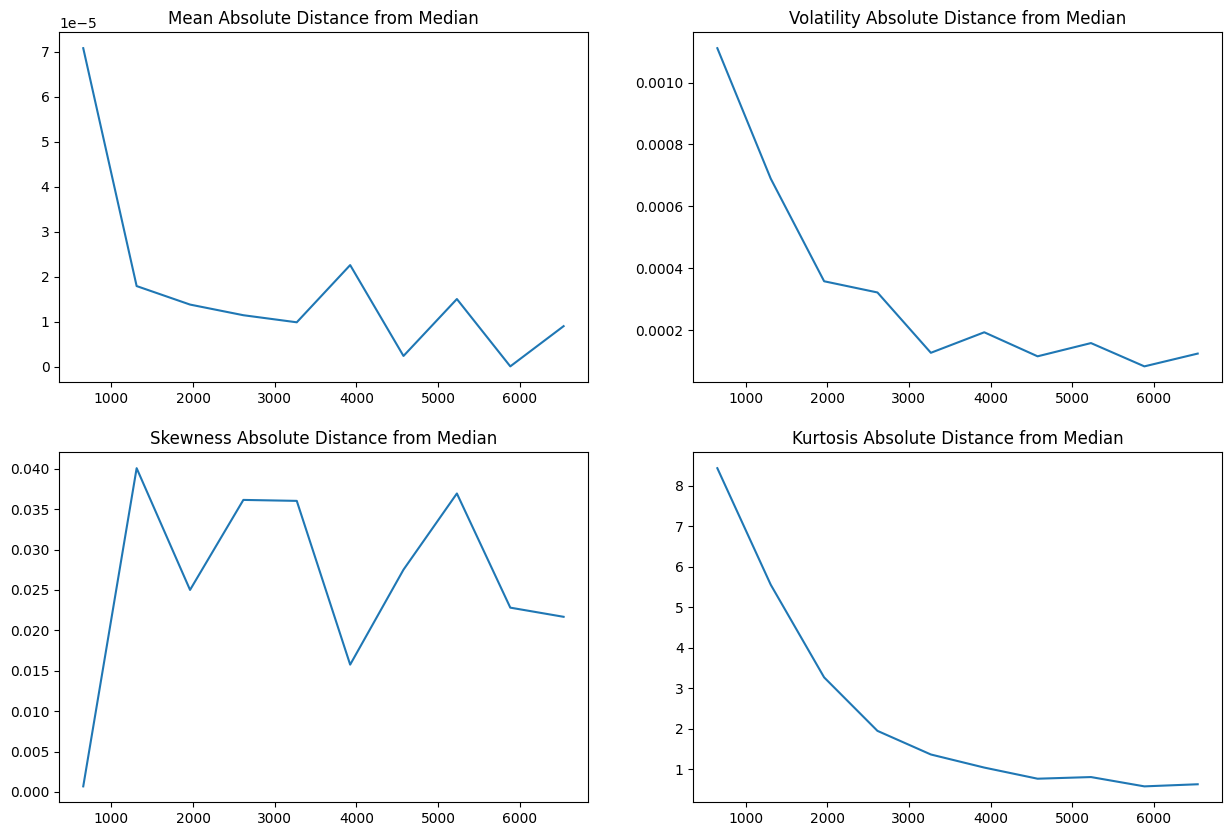

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
titles = ['Mean Absolute Distance from Median', 'Volatility Absolute Distance from Median', 'Skewness Absolute Distance from Median', 'Kurtosis Absolute Distance from Median']

for ax, col, title in zip(axes.flat, results.columns[:-1], titles):
    ax.plot(results['timesteps'], results[col])
    ax.set_title(title)

plt.show()